In [1]:
import os
import time

import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

from fuzzywuzzy import fuzz

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## 1. Load Data

In [2]:
df_movies = pd.read_csv('./movielens100k/movies.csv',
    usecols=['movie_id', 'title'],
    dtype={'movie_id': 'int32', 'title': 'str'})

df_ratings = pd.read_csv('./movielens100k/ratings.csv',
    usecols=['user_id', 'movie_id', 'rating'],
    dtype={'user_id': 'int32', 'movie_id': 'int32', 'rating': 'float32'})

In [3]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 2 columns):
movie_id    9125 non-null int32
title       9125 non-null object
dtypes: int32(1), object(1)
memory usage: 107.0+ KB


In [4]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
user_id     100004 non-null int32
movie_id    100004 non-null int32
rating      100004 non-null float32
dtypes: float32(1), int32(2)
memory usage: 1.1 MB


In [5]:
df_movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [6]:
df_ratings.head()

,user_id,movie_id,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [7]:
num_users = len(df_ratings.user_id.unique())
num_items = len(df_ratings.movie_id.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 671 unique users and 9066 unique movies in this data set


## 2. Exploratory data analysis
 - Plot the counts of each rating
 - Plot rating frequency of each movie

#### 1. Plot the counts of each rating

get the counts of each rating from ratings data

In [8]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,1101
1.0,3326
1.5,1687
2.0,7271
2.5,4449
3.0,20064
3.5,10538
4.0,28750
4.5,7723


We can see that above table does not include counts of zero rating score. So we need to add that in rating count dataframe as well

In [9]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,5983282
0.5,1101
1.0,3326
1.5,1687
2.0,7271
2.5,4449
3.0,20064
3.5,10538
4.0,28750
4.5,7723


The count for zero rating score is too big to compare with others. Take log transform for count values and plot them to compare

In [10]:
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,5983282,15.604480
0.5,1101,7.003974
1.0,3326,8.109526
1.5,1687,7.430707
2.0,7271,8.891649
2.5,4449,8.400435
3.0,20064,9.906682
3.5,10538,9.262743
4.0,28750,10.266393
4.5,7723,8.951958


Text(0, 0.5, 'number of ratings')

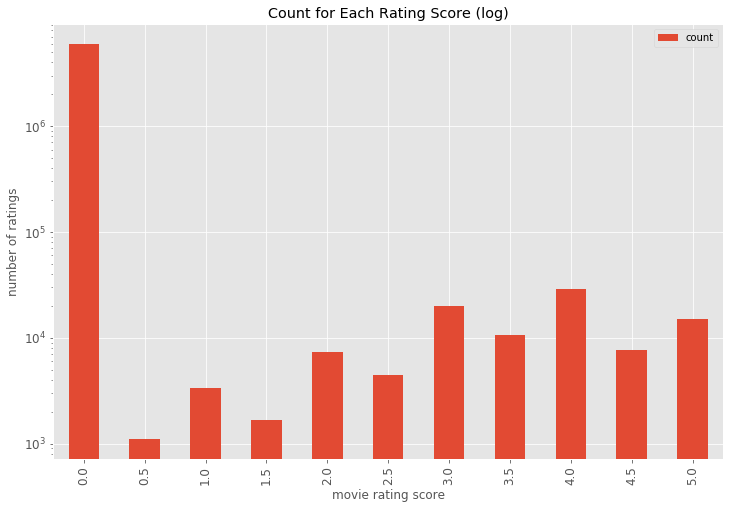

In [11]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (log)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

It's interesting that there are more people giving rating score of 3 and 4 than other scores 

#### 2. Plot rating frequency of all movies

In [12]:
df_ratings.head()

,user_id,movie_id,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [13]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movie_id').size(), columns=['count'])
df_movies_cnt.head()

,count
movie_id,
1,247
2,107
3,59
4,13
5,56


Text(0, 0.5, '# of Ratings')

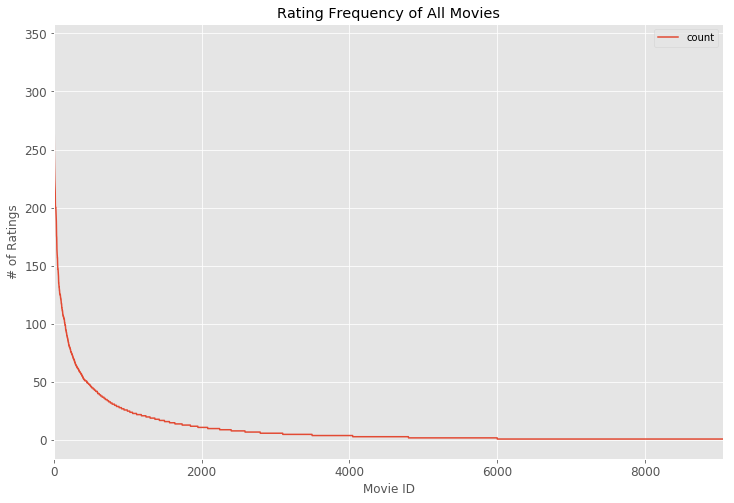

In [14]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("Movie ID")
ax.set_ylabel("# of Ratings")

    *only a small fraction of the items are rated frequently
    *These are referred to as popular items
    *majority of items are rarely rated
    *This results in a highly skewed distribution

Text(0, 0.5, 'number of ratings (log scale)')

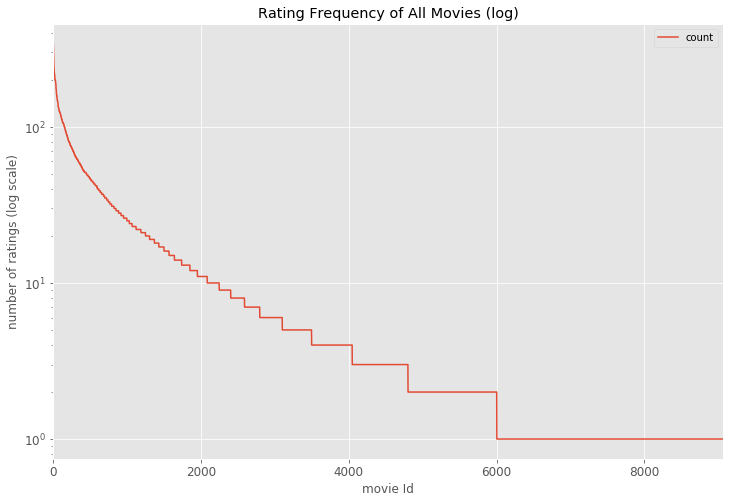

In [15]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (log)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [16]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    341.0
0.95     49.0
0.90     28.0
0.85     19.0
0.80     13.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: count, dtype: float64

In [17]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movie_id.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (100004, 3)
shape of ratings data after dropping unpopular movies:  (43083, 3)


In [18]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('user_id').size(), columns=['count'])
df_users_cnt.head()

,count
user_id,
1,3
2,56
3,30
4,106
5,76


Text(0, 0.5, '# of ratings')

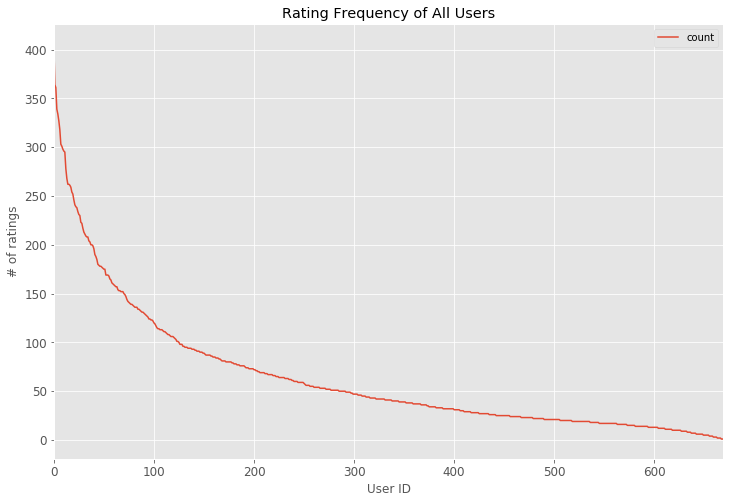

In [19]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("User ID")
ax.set_ylabel("# of ratings")

In [20]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    406.00
0.95    208.00
0.90    152.10
0.85    119.65
0.80     94.20
0.75     81.75
0.70     72.00
0.65     62.85
0.60     53.00
0.55     47.00
Name: count, dtype: float64

After dropping 75% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

    *Distribution of ratings by users =very similiar = distribution of ratings among movies
    *long-tail property
    *small fraction of users are engaged in rating movies
    *most of them do not rate at all
    *so we further reduce users

In [21]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.user_id.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (100004, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (34044, 3)


In [22]:
df_ratings_drop_users.head(10)

,user_id,movie_id,rating
20,2,10,4.0
21,2,17,5.0
22,2,39,5.0
23,2,47,4.0
24,2,50,4.0
25,2,52,3.0
26,2,62,3.0
27,2,110,4.0
29,2,150,5.0
30,2,153,4.0


## 3. Train KNN model for item-based collaborative filtering
 - Reshaping the Data
 - Fitting the Model

#### 1. Reshaping the Data

    *for knn, the data needs to be in (movie, user) array
    *each row is a movie and each column is a different user
    *pivot the dataframe to wide format with movies as rows and users as columns
    *then fill missing observations with 0s
    *perform linear algebra to calculate distance between vectors
    *then transform the values of the DF into a SciPy sparse matrix 

In [23]:
# Pivot then create movie-user matrix
movie_user_matrix = df_ratings_drop_users.pivot(index='movie_id', columns='user_id', values='rating').fillna(0)
# Create mapper from movie title to index
movie_to_index = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movie_id').loc[movie_user_matrix.index].title))
}
# Transfor matrix to a SciPy sparse
movie_user_matrix_sparse = csr_matrix(movie_user_matrix.values)

In [24]:
movie_user_matrix.head()

user_id,2,4,5,7,8,15,17,19,20,21,...,647,648,649,654,655,659,662,664,665,671
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,3.0,0.0,2.0,0.0,3.0,3.5,0.0,...,4.0,0.0,4.0,5.0,0.0,0.0,0.0,3.5,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,3.0,4.0,0.0,5.0,0.0,3.0,0.0
3,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
5,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0
6,0.0,0.0,0.0,0.0,0.0,4.0,4.5,3.0,0.0,0.0,...,4.0,4.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0


#### 2. Fitting the Model
    *Initialize the NearestNeighbors class as model_knn and fit the sparse matrix to the instance. 
    *By specifying the metric = cosine, euclidean and hamming.

In [25]:
# Model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# Fit
model_knn.fit(movie_user_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [32]:
import pickle
pickle.dump(model_knn, open('moviesKnn.pkl','wb'))

## 4. Use this trained model to make movie recommendations to myself


In [26]:
def fuzzy_matching(mapper, fav_movie, verbose=True):

    match_tuple = []
    
    # get match
    for title, index in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, index, ratio))
            
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):

    # fit
    model_knn.fit(data)
    
    # get input movie index
    print('You have input movie:', fav_movie)
    index = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[index], n_neighbors=n_recommendations+1)
    
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1} with distance {2:.4f}'.format(i+1, reverse_mapper[idx], dist))

In [31]:
fav = 'Aladdin'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_matrix_sparse,
    fav_movie=fav,
    mapper=movie_to_index,
    n_recommendations=20)

You have input movie: Aladdin
Found possible matches in our database: ['Aladdin (1992)']

Recommendation system start to make inference
......

Recommendations for Aladdin:
1: Star Wars: Episode IV - A New Hope (1977) with distance 0.4062
2: Speed (1994) with distance 0.4057
3: Fugitive, The (1993) with distance 0.4034
4: Batman Forever (1995) with distance 0.3950
5: Braveheart (1995) with distance 0.3947
6: Independence Day (a.k.a. ID4) (1996) with distance 0.3927
7: Sleepless in Seattle (1993) with distance 0.3901
8: Dances with Wolves (1990) with distance 0.3870
9: Batman (1989) with distance 0.3850
10: Men in Black (a.k.a. MIB) (1997) with distance 0.3794
11: Babe (1995) with distance 0.3771
12: Toy Story (1995) with distance 0.3738
13: Mask, The (1994) with distance 0.3711
14: Terminator 2: Judgment Day (1991) with distance 0.3654
15: True Lies (1994) with distance 0.3613
16: Forrest Gump (1994) with distance 0.3264
17: Mrs. Doubtfire (1993) with distance 0.3104
18: Jurassic Park 

    *Cosine distance of all recommendations is very small
    *Reason is there is too many zero values in the movie-user matrix
    *Data sparsity becomes an issue for KNN models and the distance in KNN model starts to fall apart

####  Diving into the missing contents in our sparse movie-user matrix by calculating % of zero's in our data

In [28]:
# Total entries in the movie-user matrix
num_entries = movie_user_matrix.shape[0] * movie_user_matrix.shape[1]

# Total entries with zero values
num_zeros = (movie_user_matrix==0).sum(axis=1).sum()

# Ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries

print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 74.26% of ratings in our data is missing


Majority of entries in our data is zero. This explains why the distance between similar items or opposite items are both pretty large.